## 1 - Import packages

In [7]:
#!pip install tensorflow[and-cuda] torch numpy wandb matplotlib monai pillow pynrrd
#!jupyter serverextension enable --py nbresuse #extension that displays the resources/computational power that are used by the notebook
#!jupyter labextension install @jupyterlab/statusbar #extension that adds a progressbar so monitoring the upload is posible

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
import torch
import plotly.graph_objects as go
import os
import numpy as np
import wandb
import matplotlib.pyplot as plt
import glob
import monai
import random
from PIL import Image
import nrrd
from monai.transforms import ToMetaTensord
from torch.utils.data import Dataset
from monai.transforms.transform import Transform
from monai.data.dataloader import DataLoader
from monai.networks.nets import UNet
from monai.networks.nets import DynUNet
from monai.data import DataLoader, CacheDataset
from monai.transforms import (
    Compose, 
    RandRotate, 
    Resize, 
    ToTensor, 
    EnsureType, 
    LoadImage, 
    EnsureChannelFirstd, 
    ScaleIntensityd,
    RandSpatialCropd,
    RandCropByPosNegLabeld,
    Pad, 
    ScaleIntensityRanged,
    Resized, 
    RandRotated,
    MapTransform,
    Spacingd,
    SpatialCropd,
    CenterSpatialCropd,
    EnsureTyped,
    RandAffined,
    RandGaussianNoised
)
from monai.losses import DiceLoss, FocalLoss, DiceCELoss, SoftclDiceLoss
from monai.optimizers import Novograd
from monai.data import MetaTensor
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from sklearn.model_selection import KFold

## 2 - Define path


In [2]:
##### CHANGE DATA PATH ACCORDINGLY #####
data_path = "ASOCA"
########################################

if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["Normal", "Diseased"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain train, val and test folders).")
else:
    print("Congrats! You selected the correct folder :)")
    
print(f'GPU index: {torch.cuda.current_device()}')  # Prints GPU index
print(f'GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}')  # Prints GPU name
print(f'You are logged in at WanB: {wandb.login()}')
print(f'Current working directory: {os.getcwd()}') 

Congrats! You selected the correct folder :)
GPU index: 0
GPU name: NVIDIA A16


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: p-a-brouwer (p-a-brouwer-university-of-twente) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


You are logged in at WanB: True
Current working directory: /home/jovyan


## 3 - Define load function, custom transform, 3D plot function, WandB logging

In [8]:
def build_dict_asoca(data_path):
    """
    This function returns a list of dictionaries, each containing the keys 'img' and 'label' 
    with paths to the corresponding NRRD image.
    
    Args:
        data_path (str): Path to the root folder of the ASOCA dataset.
        mode (str): Subset used. Must be 'train', 'val', or 'test'.
        
    Returns:
        List[Dict[str, str]]: List of dictionaries containing paths of NRRD images and labels.
    """
    
    dicts = []
    for label in ["Diseased", "Normal"]:
        image_path = os.path.join(data_path, label,"CTCA")        
        image_files = glob.glob(os.path.join(image_path, "*.nrrd"))
        
        annotation_path = os.path.join(data_path, label, "Annotations")  # Path to annotations
        
        print(f"Looking for images in: {image_path}")
        print(f"Found {len(image_files)} images in {image_path}")
        
        for img_path in image_files:
            img_name = os.path.basename(img_path)
            mask_name = os.path.basename(img_path)
            mask_path = os.path.join(annotation_path, mask_name)
        
            dicts.append({
                    'img': img_path,
                    'mask': mask_path,
                    'label': 1 if label == "Diseased" else 0  # 1 for Diseased, 0 for Normal

                })
    
    return dicts

class LoadASOCAData(Transform):
    """
    Custom MONAI transform to load ASOCA NRRD images and annotations (masks).
    """
    def __init__(self, keys=None):
        pass  # No initialization needed

    def __call__(self, sample):
        # Load image and mask
        img_path = sample['img']
        mask_path = sample['mask']
        image, _ = nrrd.read(img_path)
        mask, _ = nrrd.read(mask_path)

        # Add channel dimension (C, H, W, D)
        image = np.expand_dims(image, axis=0)  # (1, H, W, D)
        mask = np.expand_dims(mask.astype(np.float32), axis=0)  # (1, H, W, D)

        # Convert to MetaTensor (with identity affine)
        img_tensor = MetaTensor(image, affine=np.eye(4))
        mask_tensor = MetaTensor(mask, affine=np.eye(4))

        return {
            'img': img_tensor,
            'mask': mask_tensor,
            'label': torch.tensor(sample['label'], dtype=torch.long)
        }
    
class WindowLeveld(MapTransform):
    """
    Custom transform to set window and level.
    """
    def __init__(self, keys, level=200, window=400):  # Alter the W/L here
        super().__init__(keys)
        self.level = level
        self.window = window

    def __call__(self, data):
        d = dict(data)
        min_val = self.level - self.window / 2
        max_val = self.level + self.window / 2
        
        # Apply window-leveling
        img = np.clip(d["img"], min_val, max_val)
        
        # Convert back to MetaTensor while preserving metadata
        d["img"] = MetaTensor(img, meta=d["img"].meta)  # Preserve metadata!

        return d

def mask_to_point_cloud(mask_volume, voxel_spacing=(0.4, 0.4, 0.6)): #aanpassen aan de andere spacing?
    """
    Convert a 3D mask (H, W, D) into a point cloud and apply real-world scaling.

    Args:
        mask_volume (numpy array): 3D binary mask (H, W, D)
        voxel_spacing (tuple): Real-world spacing (x, y, z) in mm
    
    Returns:
        x, y, z (numpy arrays): Scaled coordinates of nonzero voxels
    """
    # Extract nonzero voxel positions
    x_idx, y_idx, z_idx = np.where(mask_volume > 0)  
    
    # Scale voxel positions to real-world dimensions
    x = x_idx * voxel_spacing[0]  
    y = y_idx * voxel_spacing[1]  
    z = z_idx * voxel_spacing[2] 
    
    return x, y, z  # Return scaled coordinates

def plot_point_cloud(x, y, z, title="3D Mask Point Cloud"):
    """
    Create a Plotly 3D scatter plot from point cloud data with real-world spacing.

    Args:
        x, y, z (numpy arrays): Scaled coordinates of nonzero voxels
        title (str): Title of the plot
    """
    fig = go.Figure(data=[go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=2, opacity=0.8, color=z, colorscale="Viridis")
    )])
    
    fig.update_layout(title=title, scene=dict(
        xaxis_title="X (mm)", 
        yaxis_title="Y (mm)", 
        zaxis_title="Z (mm)"
    ))
    
    return fig

def from_compose_to_list(compose_transform):
    return [str(transform) for transform in compose_transform.transforms]

def wandb_masks(mask_output, mask_gt):
    """ Format masks for WandB logging. """
    
    if isinstance(mask_output, np.ndarray):
        mask_output = torch.tensor(mask_output, dtype=torch.float32)
    if isinstance(mask_gt, np.ndarray):
        mask_gt = torch.tensor(mask_gt, dtype=torch.float32)
    
    # Convert to binary segmentation mask
    mask_output = torch.sigmoid(mask_output)
    mask_output = torch.round(mask_output).squeeze().clone().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().clone().detach().cpu().numpy()

    class_labels = {1: 'CTCA'}
    return {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground_truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }

def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Logs training/validation losses and visualizes predictions in WandB. """

    log_imgs = []

    for i, (img, mask_output, mask_gt) in enumerate(zip(batch_data['img'], outputs, batch_data['mask'])):
        depth = img.shape[-1]  # Extract depth
        mid_slice_idx = depth // 2  

        img_slice = img[0, :, :, mid_slice_idx].clone().detach().cpu().numpy()
        mask_output_slice = torch.sigmoid(mask_output[0, :, :, mid_slice_idx]).clone().detach().cpu().numpy()
        mask_gt_slice = mask_gt[0, :, :, mid_slice_idx].clone().detach().cpu().numpy()

        mask_output_slice = (mask_output_slice > 0.5).astype(np.uint8)
        mask_gt_slice = np.round(mask_gt_slice).astype(np.uint8)

        # Apply windowing
        Level = 250  
        window = 500
        min_val = Level - (window / 2)
        max_val = Level + (window / 2)
        img_slice = np.clip(img_slice, min_val, max_val)

         # Apply windowing
        img_slice = np.clip(img_slice, min_val, max_val)
        
        # Create a visualization figure
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(img_slice, cmap='gray')
        ax[0].set_title("Input Image")
        
        green_colormap = plt.cm.colors.ListedColormap(['black', 'green'])  # black for 0, green for 1 (or any other color scale)
        red_colormap = plt.cm.colors.ListedColormap(['black', 'red'])  # black for 0, red for 1

        # Display the ground truth mask with green colormap
        ax[1].imshow(mask_gt_slice, cmap=green_colormap)
        ax[1].set_title("Ground Truth Mask")

        # Display the predicted mask with red colormap
        ax[2].imshow(mask_output_slice, cmap=red_colormap)
        ax[2].set_title("Predicted Mask")

        plt.tight_layout()

        # Log the image and segmentation mask to WandB
        img_with_mask = wandb.Image(img_slice, masks={"predictions": {"mask_data": mask_output_slice,
                                                       "class_labels": {1: "vessel"}},
                                                      "ground_truth": {"mask_data": mask_gt_slice,
                                                                       "class_labels": {1: "vessel"}}},
            caption=f"Epoch {epoch}: Sample {i+1} CT Scan and Mask")

        log_imgs.append(img_with_mask)
        wandb.log({f"Prediction Epoch {epoch}": wandb.Image(fig)})

        plt.close(fig)  # Prevent memory leaks
        
        # Generate 3D point cloud
        mask_gt_np = mask_gt.cpu().detach().numpy()[0]
        mask_pred_np = mask_output.cpu().detach().numpy()[0]

        # Extract point cloud for GT & Predicted masks
        x_gt, y_gt, z_gt = mask_to_point_cloud(mask_gt_np)
        x_pred, y_pred, z_pred = mask_to_point_cloud(mask_pred_np)
        print(f"ground truth size: {len(x_gt)}")
        print(f"prediction size: {len(x_pred)}")
        
        # Create 3D scatter plot
        fig_gt = plot_point_cloud(x_gt, y_gt, z_gt, title=f"Sample {i+1} Ground Truth")
        fig_pred = plot_point_cloud(x_pred, y_pred, z_pred, title=f"Sample {i+1} Prediction")
        
        # Log 3D point cloud correctly
        wandb.log({f"3D GT Sample {i+1}": fig_gt})
        wandb.log({f"3D Pred Sample {i+1}": fig_pred})
        
        fig_gt.write_html("3D_GT_Sample.html")
        fig_pred.write_html("3D_Pred_Sample.html")

        # Log the HTML file to Weights & Biases
        wandb.log({
            "3D_GT_Sample": wandb.Html(open("3D_GT_Sample.html", "r").read()),
            "3D_Pred_Sample": wandb.Html(open("3D_Pred_Sample.html", "r").read()) })
        # The 3D plots are logged to WandB/project/run/files/media/html

    # Log all other shit
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'gradient_norm': torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0).item(), 
    })

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
        elif self._is_improvement(current_score):
            self.best_score = current_score
            self.counter = 0
        else:
            self.counter += 1
            print(f"🔁 No improvement for {self.counter} epochs.")
            if self.counter >= self.patience:
                self.early_stop = True
                print("🛑 Early stopping triggered.")

    def _is_improvement(self, current_score):
        if self.mode == 'min':
            return current_score < self.best_score - self.min_delta
        else:  # mode == 'max'
            return current_score > self.best_score + self.min_delta


## 4 - Define transforms

In [9]:
train_transform = Compose([
    LoadASOCAData(keys=['img', 'mask']),
    ToMetaTensord(keys=['img', 'mask']),
    ScaleIntensityRanged(keys=["img"], a_min=0, a_max=400, b_min=0.0, b_max=1.0, clip=True),
    RandAffined(keys=['img', 'mask'], prob=0.5, translate_range=10),
    RandRotated(keys=['img', 'mask'], range_x=np.deg2rad(10), range_y=np.deg2rad(10), range_z=0, prob=0.5),  # Rotation limited to ±10 degrees in x and y
    RandGaussianNoised(keys='img', prob=0.5),
    RandCropByPosNegLabeld(keys=['img', 'mask'], label_key = 'mask', spatial_size=(256,256,64), pos=1, neg=0, num_samples=1),
])

val_transform = Compose([
    LoadASOCAData(keys=['img', 'mask']),
    ToMetaTensord(keys=['img', 'mask']), 
    ScaleIntensityRanged(keys=["img"], a_min=0, a_max=400, b_min=0.0, b_max=1.0, clip=True),
    RandCropByPosNegLabeld(keys=['img', 'mask'], label_key = 'mask', spatial_size=(256, 256, 64), pos=1, neg=0, num_samples=1)
])

In [22]:
train_transform = Compose([
    LoadASOCAData(keys=['img', 'mask']),
    ToMetaTensord(keys=['img', 'mask']),
])
val_transform = Compose([
    LoadASOCAData(keys=['img', 'mask']),
    ToMetaTensord(keys=['img', 'mask']), 
])

## 5 - Define model, loss function, optimizer and set to GPU

In [19]:
#####
model = UNet(
    spatial_dims=3,
    in_channels=1,  # Grayscale image with 1 channel
    out_channels=1,  # Segmentation mask, usually 1 channel for binary segmentation
    channels=(16, 32, 64, 128),  # Number of channels in each layer
    strides=(2, 2, 1),  # Downsampling and upsampling strides, MAKE SURE THIS MATCHES THE INPUT SIZE, e.g. avoid integers
    kernel_size=3,  # Kernel size for convolutions
    dropout=0.1
)

#####
# class CombinedLoss(nn.Module):
#     def __init__(self, dice_weight=0.5, bce_weight=0.5):
#         super(CombinedLoss, self).__init__()
#         self.dice_loss = monai.losses.DiceLoss(sigmoid=True)  # Sigmoid applied internally
#         self.bce_loss = nn.BCEWithLogitsLoss()  # BCE loss

#         # Weighting between losses
#         self.dice_weight = dice_weight
#         self.bce_weight = bce_weight

#     def forward(self, outputs, targets):
#         dice = self.dice_loss(outputs, targets)
#         bce = self.bce_loss(outputs, targets)
#         return self.dice_weight * dice + self.bce_weight * bce

#loss_function = FocalLoss()
loss_function = DiceLoss(sigmoid=True)
#loss_function = CombinedLoss(dice_weight=0.5, bce_weight=0.5)
#loss_function = SoftclDiceLoss(iter_=1, smooth=1.0)
#####
optimizer = optim.Adam(model.parameters(), lr=1e-4)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, mode='max')


#####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

model.to(device)
torch.cuda.empty_cache()

The used device is cuda


## 6 - Load data

In [23]:
##### Load Data #####
data_dicts = build_dict_asoca(data_path)

# Assuming data_dicts is the list of dictionaries containing your data
train_dicts, val_dicts = train_test_split(data_dicts, test_size=0.2, random_state=42) #80/20 split , kfolds an idea in the future?

##### Create Datasets and Dataloaders #####
train_dataset = CacheDataset(data=train_dicts, transform=train_transform, cache_rate=1, num_workers=4)
val_dataset = CacheDataset(data=val_dicts, transform=val_transform, cache_rate=1, num_workers=4)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Looking for images in: ASOCA/Diseased/CTCA
Found 20 images in ASOCA/Diseased/CTCA
Looking for images in: ASOCA/Normal/CTCA
Found 20 images in ASOCA/Normal/CTCA


Loading dataset: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


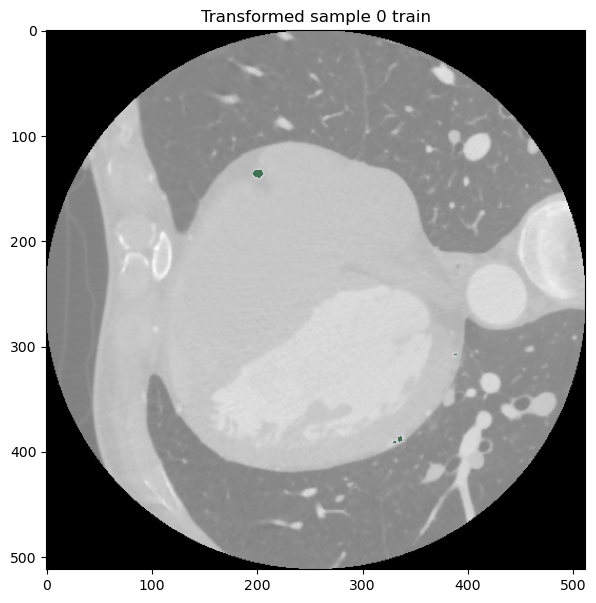

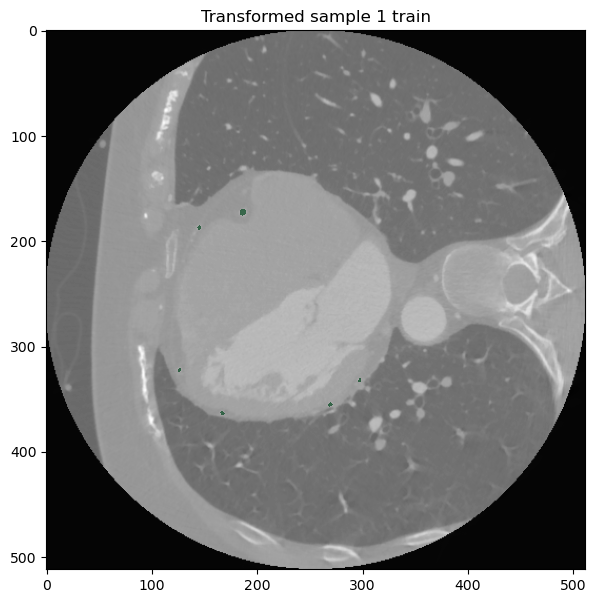

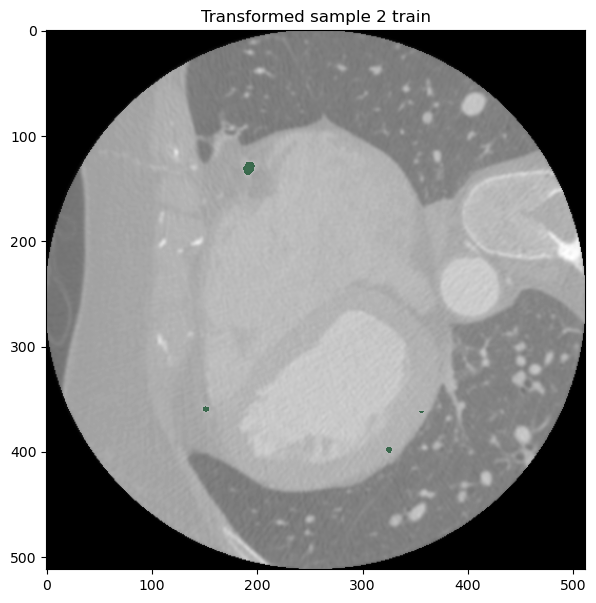

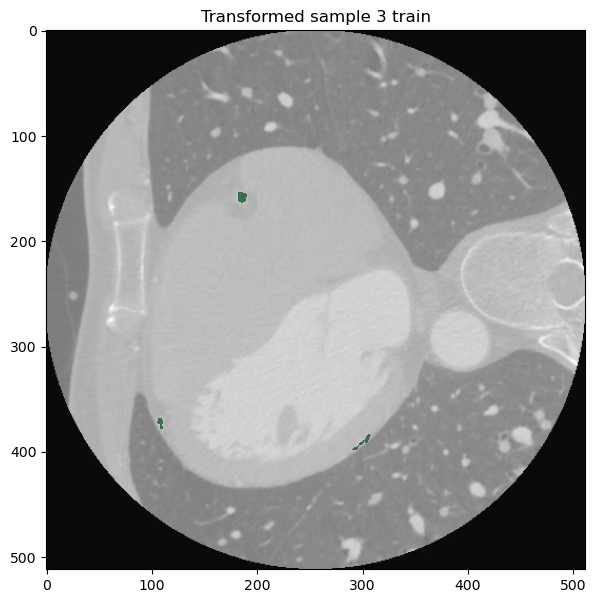

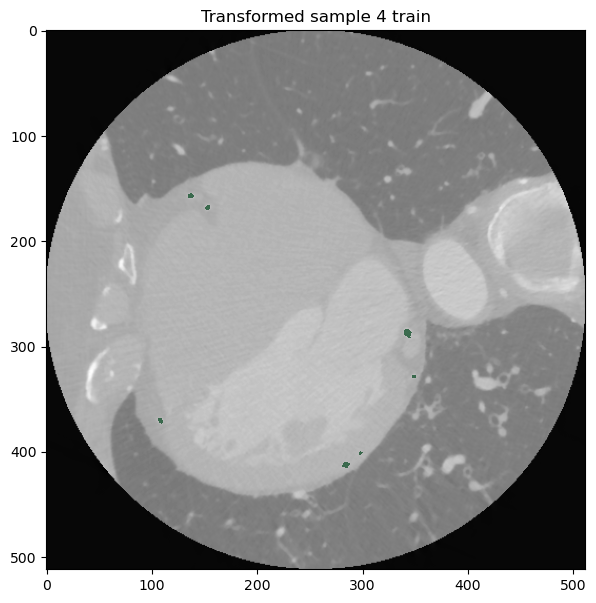

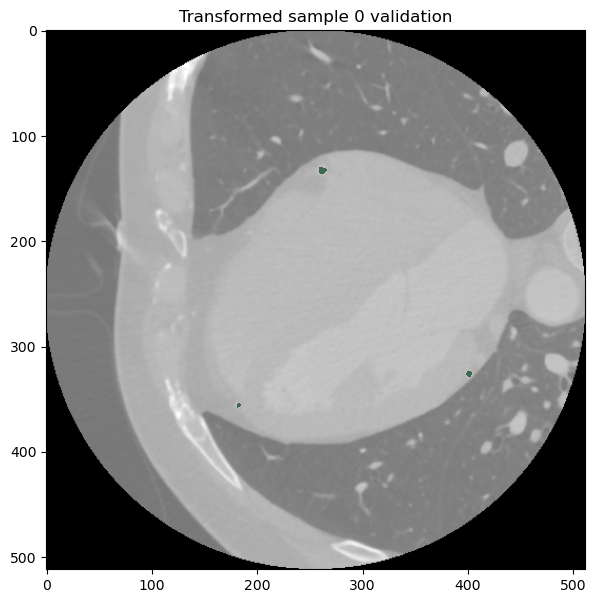

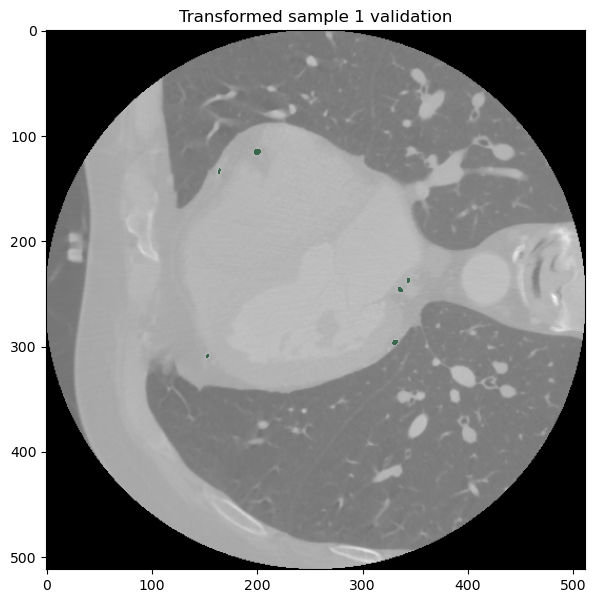

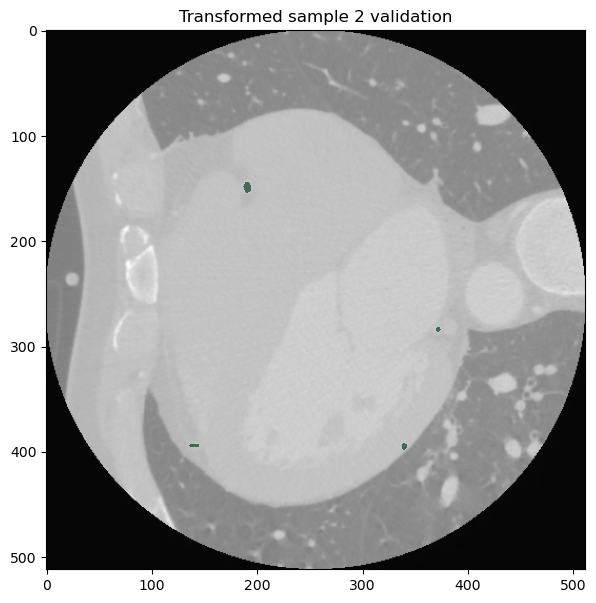

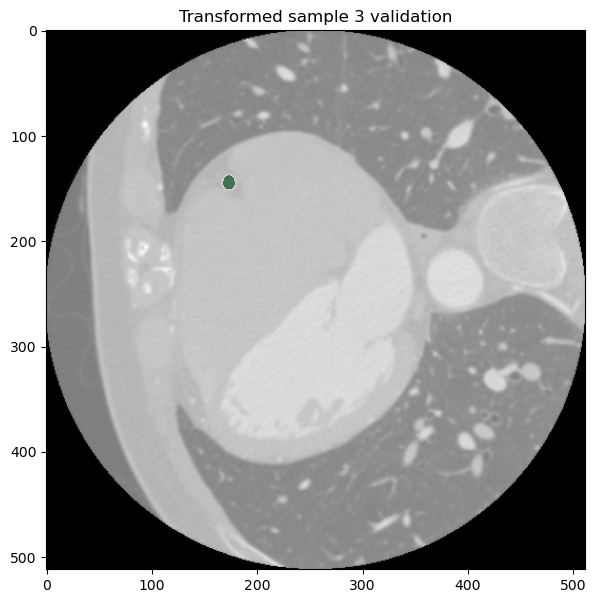

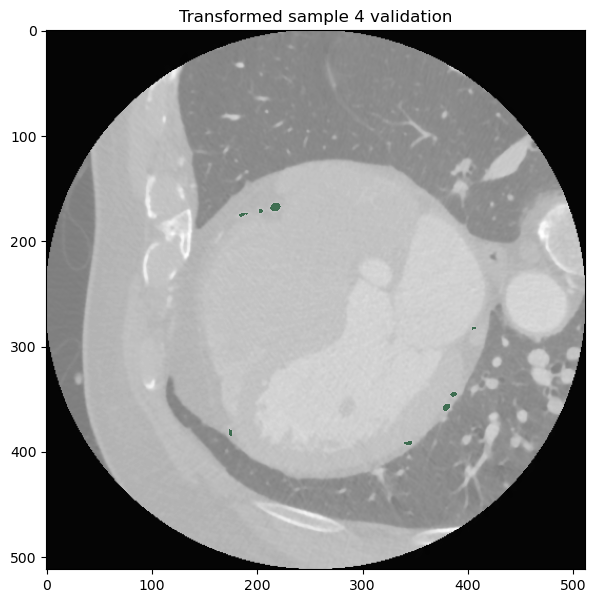

In [25]:
##### Visualization function #####
def visualize_sample(sample, title=None):
    # Visualize the x-ray and overlay the mask, using the dictionary as input
    image = np.squeeze(sample['img']) #remove channel
    mask = np.squeeze(sample['mask'])
    mid_slice = image.shape[2] // 2 # slice can be altered here
    mask_2d = mask[:,:, mid_slice]
    image_2d = image[:,:, mid_slice]     

    plt.figure(figsize=[10,7])
    plt.imshow(image_2d, 'gray')
    overlay_mask = np.ma.masked_where(mask_2d == 0, mask_2d == 1)
    plt.imshow(overlay_mask, 'Greens', alpha = 0.7, clim=[0,1], interpolation='nearest')
    if title is not None:
        plt.title(title)
    plt.show()
    
for i in range(5):
    visualize_sample(train_dataset[i], title=f"Transformed sample {i} train")
    
for i in range(5):
    visualize_sample(val_dataset[i], title=f"Transformed sample {i} validation")

## 7 - Train model

In [ ]:
run = wandb.init(
    project='ASOCA',
    name='simple_unet_training',
    config={
        'loss_function': str(loss_function),
        'lr': optimizer.param_groups[0]['lr'],
        'train_transform': from_compose_to_list(train_transform),
        'val_transform': from_compose_to_list(val_transform),
        'batch_size': train_dataloader.batch_size,
        'model_name': model.__class__.__name__,
        'optimizer': optimizer.__class__.__name__,
    },
    reinit=True
)

##### Training Loop #####
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_data in train_dataloader:
        images = batch_data['img'].to(device).float()
        masks = batch_data['mask'].to(device).float()
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = loss_function(outputs, masks)  
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_dataloader)
    
    ##### Validation #####
    model.eval()
    val_loss = 0.0
    dice_score = 0.0
    num_batches = 0
    sample_batch = None  # Store a sample batch for logging
    sample_output = None  # Store the corresponding model outputs for logging

    dice_metric = monai.metrics.DiceMetric(include_background=False, reduction="mean")

    with torch.no_grad():
        for batch_data in val_dataloader:
            images = batch_data['img'].to(device).float()
            masks = batch_data['mask'].to(device).float()
            
            outputs = model(images)
            loss = loss_function(outputs, masks)
            val_loss += loss.item()
            
            # Ensure binary masks
            outputs = (outputs > 0.8).float()
            outputs = torch.clamp(outputs, min=1e-4, max=1.0)  # just in case
            masks = (masks > 0).float()
            
            # Compute Dice Score safely
            if torch.sum(masks) > 0:  # Ensure non-empty mask
                batch_dice = dice_metric(outputs, masks)
                if not torch.isnan(batch_dice):
                    dice_score += batch_dice.item()
                else:
                    print(f"⚠️ Warning: NaN Dice score in batch {num_batches}!")
            else:
                print(f"⚠️ Skipping batch {num_batches}: Empty mask.")

            num_batches += 1
            
            # Store first batch for visualisation and its outputs
            if sample_batch is None:
                sample_batch = batch_data  # Store input batch (images, masks)
                sample_output = outputs.detach().cpu()  # Store the model's outputs (predictions) for this batch

    avg_val_loss = val_loss / num_batches if num_batches > 0 else 0
    avg_dice_score = dice_score / num_batches if num_batches > 0 else 0  
    scheduler.step(avg_val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Dice: {avg_dice_score}")
    early_stopping(avg_dice_score)
    if early_stopping.early_stop:
        print("✅ Stopping training early at epoch", epoch + 1)
        break

    # Log to WandB
    log_to_wandb(epoch, avg_train_loss, avg_val_loss, sample_batch, sample_output)

##### Save Model #####
torch.save(model.state_dict(), "simple_segmentation_model.pth")
wandb.save("simple_segmentation_model.pth")

run.finish()

Epoch 1/150, Training Loss: 0.9943525362759829, Validation Loss: 0.9919966161251068, Dice: 0.026467851945199072
ground truth size: 1596
prediction size: 4194304
Epoch 2/150, Training Loss: 0.9932883158326149, Validation Loss: 0.9918530955910683, Dice: 0.028268178110010922
ground truth size: 6845
prediction size: 4194304
Epoch 3/150, Training Loss: 0.9914392400532961, Validation Loss: 0.9918383583426476, Dice: 0.028974548331461847
🔁 No improvement for 1 epochs.
ground truth size: 7067
prediction size: 4194304
Epoch 4/150, Training Loss: 0.9916096534579992, Validation Loss: 0.9917905926704407, Dice: 0.029387120041064918
ground truth size: 6496
prediction size: 4194304
Epoch 5/150, Training Loss: 0.9914769399911165, Validation Loss: 0.9897484853863716, Dice: 0.03613602835685015
ground truth size: 6951
prediction size: 4194304
Epoch 6/150, Training Loss: 0.9905918855220079, Validation Loss: 0.991510808467865, Dice: 0.031969913630746305
🔁 No improvement for 1 epochs.
ground truth size: 8256

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


Epoch 58/150, Training Loss: 0.6877863015979528, Validation Loss: 0.7472551837563515, Dice: 0.5116077251732349
🔁 No improvement for 4 epochs.
ground truth size: 7722
prediction size: 4194304
Epoch 59/150, Training Loss: 0.6838543619960546, Validation Loss: 0.6654811948537827, Dice: 0.603154581040144
🔁 No improvement for 5 epochs.
ground truth size: 1638
prediction size: 4194304
Epoch 60/150, Training Loss: 0.6760929152369499, Validation Loss: 0.6601954102516174, Dice: 0.6138389520347118
🔁 No improvement for 6 epochs.
ground truth size: 7911
prediction size: 4194304
Epoch 61/150, Training Loss: 0.6562532428652048, Validation Loss: 0.7030257061123848, Dice: 0.5823622792959213
🔁 No improvement for 7 epochs.
ground truth size: 2821
prediction size: 4194304
Epoch 62/150, Training Loss: 0.6636398956179619, Validation Loss: 0.6845299303531647, Dice: 0.5766413994133472
🔁 No improvement for 8 epochs.
ground truth size: 3520
prediction size: 4194304
Epoch 63/150, Training Loss: 0.650707865133881

## 8 - Segment secret test set

In [124]:
model.eval()
test_path = "ASOCA_secret"
test_files = sorted([f for f in os.listdir(test_path)])

from monai.transforms import MapTransform

class KeepFilenamed(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = data[key]
        return d

test_transforms = Compose([
    WindowLeveld(keys=['img']), 
    ScaleIntensityd(keys=['img'], minv=0, maxv=1),
    ToMetaTensord(keys=['img']),
    KeepFilenamed(keys=["filename"])
])

output_dir = "ASOCA_segmentations"
os.makedirs(output_dir, exist_ok=True)


In [125]:
import nibabel as nib
import numpy as np
from monai.data import MetaTensor

class LoadASOCADataTest:
    """
    Custom transform for loading ASOCA data in NIfTI format and preserving metadata.
    """
    def __init__(self, keys=None):
        self.keys = keys  # Store the keys in case you need to use them

    def __call__(self, sample):
        img_path = sample['img']
        
        # Load the NIfTI image using nibabel
        img_data = nib.load(img_path)
        
        # Get the image data as a NumPy array
        image = img_data.get_fdata()

        # Optionally, you can perform any slicing or operations on `image` here
        # For example, if you want to add a new axis (e.g., for channels):
        image = np.expand_dims(image, axis=0)  # Shape: (1, H, W, D)

        # Create a MetaTensor to preserve metadata like affine matrix
        img_tensor = MetaTensor(image, affine=img_data.affine)
        
        # Return the transformed sample with the image and its metadata
        return {'img': img_tensor}


In [140]:
import os
import torch
import numpy as np
import nrrd
from monai.transforms import Compose
from monai.networks.nets import UNet
from tqdm import tqdm
from monai.data import DataLoader, Dataset

# Configuration
asoca_secret_dir = "ASOCA_secret/forDLMIA/"
output_dir = "./predictions_nrrd/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create output folder
os.makedirs(output_dir, exist_ok=True)

# Inference transforms (same as during training, but no cropping, no augmentation)
test_transform = Compose([
    LoadASOCADataTest(keys=['img']),
    WindowLeveld(keys=['img']),
    ScaleIntensityd(keys=['img'], minv=0, maxv=1),
    CenterSpatialCropd(keys=['img'], roi_size=(512,512,168))
])

# Create dataset
image_filenames = [f for f in os.listdir(asoca_secret_dir)]
data_dicts = [{"img": os.path.join(asoca_secret_dir, fname)} for fname in image_filenames]


dataset = Dataset(data=data_dicts, transform=test_transform)
loader = DataLoader(dataset, batch_size=1, num_workers=4)

with torch.no_grad():
    for batch in tqdm(loader):
        img_path = batch["img"]
        image = batch["img"].to(device).float()

        output = model(image)
        pred = (torch.sigmoid(output) > 0.8).float()
        pred_np = pred.cpu().numpy().astype(np.uint8)[0, 0]

        # Save result using original filename
        out_fname = filename.replace(".nii.gz", "_seg.nii.gz")
        out_path = os.path.join(output_dir, out_fname)
        nib.save(nib.Nifti1Image(pred_np, np.eye(4)), out_path)


print(f"Inference complete. Segmentations saved to: {output_dir}")


  0%|          | 0/20 [00:09<?, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)

In [134]:
model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(loader)):
        image = batch["img"].to(device).float()
        
        # Get the original filename from the dataset
        fname = os.path.basename(dataset.data[i]["img"])

        output = model(image)
        pred = (torch.sigmoid(output) > 0.8).float()
        pred_np = pred.cpu().numpy().astype(np.uint8)[0, 0]

        out_fname = fname.replace(".nii.gz", "_seg.nii.gz")
        out_path = os.path.join(output_dir, out_fname)

        # Optional: preserve affine if needed
        nib.save(nib.Nifti1Image(pred_np, np.eye(4)), out_path)


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


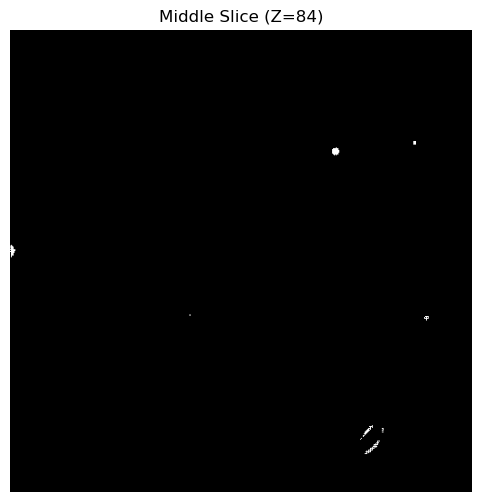

In [108]:
import nibabel as nib
import matplotlib.pyplot as plt

def view_nifti_image(img_path):
    """
    Function to view a NIfTI image in a Jupyter notebook.
    It will display the middle slice along the z-axis.

    Args:
    img_path (str): Path to the NIfTI file.
    """
    # Load the NIfTI image (handles .nii and .nii.gz automatically)
    img_data = nib.load(img_path)

    # Get the image data as a NumPy array
    image = img_data.get_fdata()

    # Determine the middle slice along the z-axis (3rd dimension)
    middle_slice = image.shape[2] // 2

    # Plot the middle slice
    plt.figure(figsize=(6, 6))
    plt.imshow(image[:, :, middle_slice], cmap='gray')
    plt.axis('off')
    plt.title(f"Middle Slice (Z={middle_slice})")
    plt.show()

# Example usage
view_nifti_image('predictions_nrrd/1.img.nii.gz')


In [106]:
import numpy as np

def uncrop_to_original(pred_cropped: np.ndarray, original_shape: tuple) -> np.ndarray:
    """
    Place a smaller cropped prediction array in the centre of a larger array with the original shape.
    
    Args:
        pred_cropped (np.ndarray): Cropped prediction array.
        original_shape (tuple): Target shape to embed the cropped array into.

    Returns:
        np.ndarray: An array with the same shape as `original_shape`, 
                    with the `pred_cropped` embedded in the centre.
    """
    padded = np.zeros(original_shape, dtype=pred_cropped.dtype)

    crop_shape = pred_cropped.shape
    start = [(o - c) // 2 for o, c in zip(original_shape, crop_shape)]
    end = [start[i] + crop_shape[i] for i in range(3)]

    padded[start[0]:end[0], start[1]:end[1], start[2]:end[2]] = pred_cropped
    return padded


In [138]:
def visualize(sample,sample2, voxel_spacing=(0.4, 0.4, 0.6), title="3D Mask Point Cloud"):
    """
    Visualize 2 maks from a sample as 3D point clouds.

    Args:
        sample (dict): A sample dict containing 'mask' and 'prediction' tensors.
        voxel_spacing (tuple): Real-world voxel spacing in mm (x, y, z).
    """
    def mask_to_point_cloud(mask, spacing):
        x_idx, y_idx, z_idx = np.where(mask > 0)
        x = x_idx * spacing[0]
        y = y_idx * spacing[1]
        z = z_idx * spacing[2]
        return x, y, z

    # Extract and convert masks
    gt_mask = sample[0]
    pred_mask = sample2[0]
    x_gt, y_gt, z_gt = mask_to_point_cloud(gt_mask, voxel_spacing)
    x_pred, y_pred, z_pred = mask_to_point_cloud(pred_mask, voxel_spacing)

    # Compute fixed axis limits from ground truth shape
    shape = gt_mask.shape
    x_range = [0, shape[0] * voxel_spacing[0]]
    y_range = [0, shape[1] * voxel_spacing[1]]
    z_range = [0, shape[2] * voxel_spacing[2]]

    # Create the figure
    fig = go.Figure()

    # Add ground truth
    fig.add_trace(go.Scatter3d(
        x=x_gt, y=y_gt, z=z_gt,
        mode='markers',
        name='Ground Truth',
        marker=dict(size=2, color='green', opacity=0.5)
    ))

    # Add prediction
    fig.add_trace(go.Scatter3d(
        x=x_pred, y=y_pred, z=z_pred,
        mode='markers',
        name='Prediction',
        marker=dict(size=2, color='red', opacity=0.5)
    ))

    # Layout with fixed limits and toggleable legend
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(title='X (mm)', range=x_range),
            yaxis=dict(title='Y (mm)', range=y_range),
            zaxis=dict(title='Z (mm)', range=z_range),
            aspectmode='manual',
            aspectratio=dict(
                x=(x_range[1]) / (x_range[1]),
                y=(y_range[1]) / (x_range[1]),
                z=(z_range[1]) / (x_range[1])
            )
        ),
        legend=dict(itemsizing='constant')
    )

    return fig

In [139]:
fig = visualize(image,image)

ValueError: too many values to unpack (expected 3)

In [117]:
import nibabel as nib
import numpy as np

def uncrop_to_original(pred_cropped: np.ndarray, original_shape: tuple) -> np.ndarray:
    padded = np.zeros(original_shape, dtype=pred_cropped.dtype)
    crop_shape = pred_cropped.shape
    start = [(o - c) // 2 for o, c in zip(original_shape, crop_shape)]
    end = [start[i] + crop_shape[i] for i in range(3)]
    padded[start[0]:end[0], start[1]:end[1], start[2]:end[2]] = pred_cropped
    return padded

# Paths
pred_path = 'predictions_nrrd/1.img.nii.gz'
gt_path = 'ASOCA_secret/forDLMIA/1.img.nii.gz'
output_path = 'predictions_nrrd/1.img_uncropped.nii.gz'

# Load prediction and ground truth
pred_img = nib.load(pred_path)
gt_img = nib.load(gt_path)

pred_cropped = pred_img.get_fdata()
original_shape = gt_img.shape

# Apply uncropping
pred_uncropped = uncrop_to_original(pred_cropped, original_shape)

# Save the result
pred_nifti = nib.Nifti1Image(pred_uncropped, affine=gt_img.affine)
nib.save(pred_nifti, output_path)

print(f"Saved uncropped prediction to: {output_path}")



Saved uncropped prediction to: predictions_nrrd/1.img_uncropped.nii.gz


In [34]:
import nibabel as nib
import numpy as np
from monai.data import MetaTensor

class LoadASOCADataTest:
    """
    Custom transform for loading ASOCA data in NIfTI format and preserving metadata.
    """
    def __init__(self, keys=None):
        self.keys = keys

    def __call__(self, sample):
        img_path = sample['img']
        
        # Load the NIfTI image using nibabel
        img_data = nib.load(img_path)
        
        # Get the image data as a NumPy array
        image = img_data.get_fdata()

        # Expand dimensions if needed (e.g., for channel-first format)
        image = np.expand_dims(image, axis=0)  # Shape: (1, H, W, D)

        # Create a MetaTensor with image data and affine matrix
        img_tensor = MetaTensor(image, affine=img_data.affine)
        
        return {'img': img_tensor}

In [35]:
import os
import torch
import numpy as np
import nibabel as nib
from tqdm import tqdm
from monai.transforms import (
    Compose,
    ScaleIntensityRanged,
)
from monai.inferers import sliding_window_inference
from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet

# ===== Custom transform loader you defined earlier =====


# ===== Model setup =====
model = UNet(
    spatial_dims=3,
    in_channels=1,  # Grayscale image with 1 channel
    out_channels=1,  # Segmentation mask, usually 1 channel for binary segmentation
    channels=(16, 32, 64, 128),  # Number of channels in each layer
    strides=(2, 2, 1),  # Downsampling and upsampling strides, MAKE SURE THIS MATCHES THE INPUT SIZE, e.g. avoid integers
    kernel_size=3  # Kernel size for convolutions
)
model.load_state_dict(torch.load("simple_segmentation_model.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ===== Test data directories =====
test_images_dir = "ASOCA_secret/forDLMIA"
test_labels_dir = "path_to_test_labels"  # Optional — used only for metrics

# ===== Gather test image paths =====
test_images = sorted([
    os.path.join(test_images_dir, f)
    for f in os.listdir(test_images_dir)
    if f.endswith(".nii.gz")
])
test_labels = sorted([
    os.path.join(test_labels_dir, f)
    for f in os.listdir(test_labels_dir)
    if f.endswith(".nii.gz")
]) if os.path.exists(test_labels_dir) else None

# ===== Dataset dictionary =====
if test_labels:
    test_data = [{"img": img, "label": label} for img, label in zip(test_images, test_labels)]
else:
    test_data = [{"img": img} for img in test_images]

# ===== Transforms =====
test_transforms = Compose([
    LoadASOCADataTest(keys=["img"]),
    ScaleIntensityRanged(keys=["img"], a_min=0, a_max=400, b_min=0.0, b_max=1.0, clip=True),
])

# ===== DataLoader =====
test_dataset = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=4)

# ===== Inference parameters =====
patch_size = (256, 256, 64)
overlap = 0.25
output_dir = "predictions"
os.makedirs(output_dir, exist_ok=True)

# ===== Inference loop =====
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        img = batch["img"].to(device).float()

        # Sliding window inference
        pred = sliding_window_inference(img, patch_size, 4, model)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.8).float()

        # Convert to NumPy (remove batch and channel)
        pred_np = pred.cpu().numpy()[0, 0]

        # Handle affine safely
        affine = batch["img"].affine[0] if hasattr(batch["img"], "affine") else np.eye(4)
        if affine.shape != (4, 4):
            print(f"Warning: Invalid affine shape {affine.shape}. Using identity.")
            affine = np.eye(4)

        # Save prediction
        filename = os.path.basename(test_images[i])
        save_path = os.path.join(output_dir, filename)
        nib.save(nib.Nifti1Image(pred_np, affine), save_path)
        print(f"Saved prediction: {save_path}")

print("✅ Inference completed!")


  5%|▌         | 1/20 [00:11<03:47, 11.98s/it]

Saved prediction: predictions/1.img.nii.gz


 10%|█         | 2/20 [00:15<02:07,  7.10s/it]

Saved prediction: predictions/10.img.nii.gz


 15%|█▌        | 3/20 [00:19<01:34,  5.56s/it]

Saved prediction: predictions/11.img.nii.gz


 20%|██        | 4/20 [00:23<01:17,  4.81s/it]

Saved prediction: predictions/12.img.nii.gz


 25%|██▌       | 5/20 [00:26<01:03,  4.21s/it]

Saved prediction: predictions/13.img.nii.gz


 30%|███       | 6/20 [00:29<00:56,  4.02s/it]

Saved prediction: predictions/14.img.nii.gz


 35%|███▌      | 7/20 [00:32<00:46,  3.56s/it]

Saved prediction: predictions/15.img.nii.gz


 40%|████      | 8/20 [00:36<00:43,  3.60s/it]

Saved prediction: predictions/16.img.nii.gz


 45%|████▌     | 9/20 [00:39<00:39,  3.63s/it]

Saved prediction: predictions/17.img.nii.gz


 50%|█████     | 10/20 [00:42<00:33,  3.32s/it]

Saved prediction: predictions/18.img.nii.gz


 55%|█████▌    | 11/20 [00:46<00:30,  3.43s/it]

Saved prediction: predictions/19.img.nii.gz


 60%|██████    | 12/20 [00:49<00:28,  3.51s/it]

Saved prediction: predictions/2.img.nii.gz


 65%|██████▌   | 13/20 [00:53<00:24,  3.56s/it]

Saved prediction: predictions/20.img.nii.gz


 70%|███████   | 14/20 [00:57<00:21,  3.60s/it]

Saved prediction: predictions/3.img.nii.gz


 75%|███████▌  | 15/20 [01:00<00:17,  3.59s/it]

Saved prediction: predictions/4.img.nii.gz


 80%|████████  | 16/20 [01:03<00:13,  3.29s/it]

Saved prediction: predictions/5.img.nii.gz


 85%|████████▌ | 17/20 [01:07<00:10,  3.40s/it]

Saved prediction: predictions/6.img.nii.gz


 90%|█████████ | 18/20 [01:09<00:06,  3.16s/it]

Saved prediction: predictions/7.img.nii.gz


 95%|█████████▌| 19/20 [01:13<00:03,  3.31s/it]

Saved prediction: predictions/8.img.nii.gz


100%|██████████| 20/20 [01:17<00:00,  3.43s/it]

Saved prediction: predictions/9.img.nii.gz


100%|██████████| 20/20 [01:17<00:00,  3.89s/it]

✅ Inference completed!
